In [1]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
dtypes = {"item_id": object, "brand_id": object, "user_id": object}

knownpath = os.path.join("..", "data", "BADS_WS1819_known.csv")
known = pd.read_csv(knownpath, parse_dates=["order_date", "delivery_date",
                                            "user_dob", "user_reg_date"],
                    index_col=["order_item_id"], dtype=dtypes,
                    na_values=["not_reported", "?"])

In [3]:
unknownpath = os.path.join("..", "data", "BADS_WS1819_unknown.csv")
unknown = pd.read_csv(unknownpath, parse_dates=["order_date", "delivery_date",
                                                "user_dob", "user_reg_date"],
                      index_col=["order_item_id"], dtype=dtypes)

In [4]:
known.head()

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
ID1,2016-05-13,2016-05-16,1040,38,red,138,69.9,19065,Mrs,NaT,Lower Saxony,2016-05-14,1
ID2,2016-09-26,NaT,4490,m,grey,133,59.9,32349,Mrs,1967-02-21,North Rhine-Westphalia,2015-02-17,0
ID3,2017-02-28,2017-05-09,4792,m,ecru,128,99.9,74743,Mrs,NaT,North Rhine-Westphalia,2017-02-14,0
ID4,2017-01-23,2017-01-24,4686,L,terracotta,105,59.9,32935,Mrs,1961-01-08,North Rhine-Westphalia,2015-02-17,0
ID5,2016-05-13,2016-05-16,648,39,petrol,170,139.9,2842,Mrs,1966-05-01,Schleswig-Holstein,2015-04-06,1


## Some of the date-columns seem off


1. First delivery_date is from 1994 - but the first order date is in 2016 - something is fishy...
2. First `user_dob` is in 1900 - investigate if this is only one person.
3. Also `user_dob` has a lot of missing values. Maybe use this as a feature?
4. The youngest user is freaking **6 years old**

## Some of the other columns also seem off

1. Price is zero on some occasions - this may be genuine, if it is a price-promotion of some sorts.
2. Can one harmonize the `item_size` column? - I tend to say no...
3. Keep missing colors as NAs.

In [5]:
known.describe(include="all")

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
count,100000,91708,100000,100000,99966,100000,100000.000000,100000,100000,89977,100000,100000,100000.000000
unique,365,319,2656,114,84,155,NaN,37663,5,12121,16,775,NaN
top,2016-06-27 00:00:00,2017-04-04 00:00:00,3066,l,black,103,NaN,2649,Mrs,1900-11-21 00:00:00,North Rhine-Westphalia,2015-02-17 00:00:00,NaN
freq,1100,1129,756,7599,17896,13370,NaN,81,95976,858,23370,29416,NaN
first,2016-04-01 00:00:00,1994-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-11-21 00:00:00,NaN,2015-02-17 00:00:00,NaN
last,2017-03-31 00:00:00,2017-07-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-12 00:00:00,NaN,2017-04-01 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,70.279143,NaN,NaN,NaN,NaN,NaN,0.481740
std,NaN,NaN,NaN,NaN,NaN,NaN,44.973992,NaN,NaN,NaN,NaN,NaN,0.499669
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,34.900000,NaN,NaN,NaN,NaN,NaN,0.000000


In [6]:
known.isna().sum()

order_date           0
delivery_date     8292
item_id              0
item_size            0
item_color          34
brand_id             0
item_price           0
user_id              0
user_title           0
user_dob         10023
user_state           0
user_reg_date        0
return               0
dtype: int64

## 1. Fix `delivery_date` column

* Find out, whats the median days between `order_date` and `delivery_date`
* Replace missing values by median

First: set all weird delivery date values to NA - because that's what they are

In [7]:
wrong_deli = known["delivery_date"] == known["delivery_date"].min()
known.loc[wrong_deli, "delivery_date"] = np.nan

In [8]:
dul = (known["delivery_date"] - known["order_date"]).dt.days
known["days_until_delivery"] = dul

### Plot overall distribution

<BarContainer object of 9398 artists>

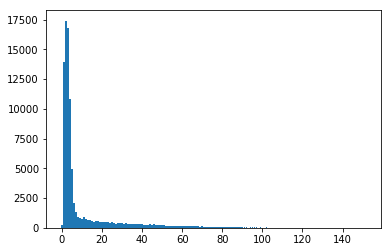

In [9]:
total_val, total_counts = np.unique(known["days_until_delivery"].values,
                                    return_counts=True)

fig, ax = plt.subplots()
ax.bar(total_val, total_counts)

In [10]:
total_median = np.nanpercentile(total_counts, 50)
total_median

1.0

### Plot distribution conditional on return

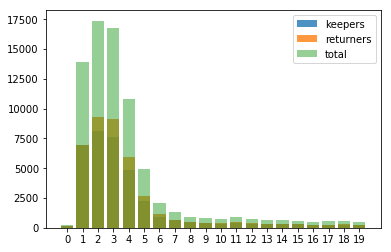

In [16]:
returners = known.loc[known["return"] == 1, "days_until_delivery"]
keepers = known.loc[known["return"] == 0, "days_until_delivery"]

keepers_val, keepers_counts = np.unique(keepers.values, return_counts=True)
returners_val, returners_counts = np.unique(returners.values,
                                            return_counts=True)


fig, ax = plt.subplots()
ax.bar(keepers_val[:20], keepers_counts[:20], alpha=0.8, label="keepers")
ax.bar(returners_val[:20], returners_counts[:20], alpha=0.8, label="returners")
ax.bar(total_val[:20], total_counts[:20], alpha=0.5, label="total")
plt.legend()
plt.xticks(total_val[:20]);

In [11]:
keepers_median = np.nanpercentile(keepers_counts, 50)
keepers_median

NameError: name 'keepers_counts' is not defined

In [ ]:
returners_median = np.nanpercentile(returners_counts, 50)
returners_median

### Impute missing `delivery_date` values

Turns out the median for all different groups is 1 - However, I am not buying it. We replace everything by 2.

In [ ]:
isna_dul = known.delivery_date.isna()
known.loc[isna_dul, "delivery_date"] = known.order_date + pd.to_timedelta(2, 'd')
known.loc[known.days_until_delivery.isna(), "days_until_delivery"] = 2

In [ ]:
known.isna().sum()

In [ ]:
known.head(10)

## 2. Deal with our Methusalems

In [ ]:
known.loc[known.user_dob == known.user_dob.min()].head()

Maybe these are shenanigans introduced by Alisa/Johannes/Lessman?

In [12]:
known.loc[(known.user_id == "35638") | (known.user_id == "26587"),
          ["user_dob", "user_id"]]

,user_dob,user_id
order_item_id,,
ID15664,1900-11-21,26587
ID51929,1900-11-21,26587
ID59533,1900-11-21,26587
ID74288,1900-11-21,26587
ID99398,1900-11-21,35638
ID99740,1900-11-21,26587


Nope, does not seem so... It's again one of these annoying missing value codes...

In [13]:
known.loc[known.user_dob == pd.to_datetime("1900-11-21"), "user_dob"] = np.nan
known.head()

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,days_until_delivery
order_item_id,,,,,,,,,,,,,,
ID1,2016-05-13,2016-05-16,1040,38,red,138,69.9,19065,Mrs,NaT,Lower Saxony,2016-05-14,1,3.0
ID2,2016-09-26,NaT,4490,m,grey,133,59.9,32349,Mrs,1967-02-21,North Rhine-Westphalia,2015-02-17,0,NaN
ID3,2017-02-28,2017-05-09,4792,m,ecru,128,99.9,74743,Mrs,NaT,North Rhine-Westphalia,2017-02-14,0,70.0
ID4,2017-01-23,2017-01-24,4686,L,terracotta,105,59.9,32935,Mrs,1961-01-08,North Rhine-Westphalia,2015-02-17,0,1.0
ID5,2016-05-13,2016-05-16,648,39,petrol,170,139.9,2842,Mrs,1966-05-01,Schleswig-Holstein,2015-04-06,1,3.0


## Deal with our youngest

**WTF** is going on?

In [14]:
known.loc[known.user_dob == known.user_dob.max()]

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,days_until_delivery
order_item_id,,,,,,,,,,,,,,
ID98918,2016-12-22,2017-01-01,4228,40,grey,117,139.9,64911,Mrs,2012-11-12,North Rhine-Westphalia,2016-12-11,0,10.0


Alrighty, this might be a parent, ordering something for her kid...

# Other assorted columns

## 1. Zero prices - what is up with that?

In [15]:
zero_price = known.loc[known.item_price == 0]
zero_price

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,days_until_delivery
order_item_id,,,,,,,,,,,,,,
ID126,2016-06-29,NaT,316,unsized,purple,132,0.0,1867,Mrs,1965-04-08,Bremen,2015-02-17,0,NaN
ID308,2016-06-17,2016-06-19,126,unsized,white,105,0.0,29405,Mrs,1970-10-25,Berlin,2016-06-18,0,2.0
ID346,2016-06-02,2016-06-04,316,unsized,purple,132,0.0,22073,Mrs,NaT,Lower Saxony,2015-02-17,0,2.0
ID382,2016-07-05,2016-07-30,480,unsized,brown,160,0.0,31284,Mrs,1955-01-14,North Rhine-Westphalia,2016-06-24,0,25.0
ID421,2016-10-11,2016-12-21,2946,unsized,brown,160,0.0,589,Mrs,NaT,North Rhine-Westphalia,2016-03-26,0,71.0
ID904,2016-04-30,2016-05-01,316,unsized,purple,132,0.0,14858,Mrs,1946-03-26,North Rhine-Westphalia,2016-03-08,0,1.0
ID1033,2016-11-30,2016-12-20,3904,unsized,silver,226,0.0,25545,Mr,1962-01-31,Bavaria,2015-05-03,0,20.0
ID1280,2016-06-25,2016-06-26,316,unsized,purple,132,0.0,6960,Mrs,1968-03-05,Schleswig-Holstein,2015-02-17,0,1.0
ID1303,2016-06-11,2016-06-13,316,unsized,purple,132,0.0,17907,Mrs,NaT,Berlin,2016-06-12,0,2.0


In [16]:
zero_price.shape[0]

356

In [17]:
zero_price.item_id.nunique()

25

Nope, seems fine. These seem to be some rewards for loyalty...

# Colors are fucked up too...

some are underrepresented, some are just bullshit words for more simple colors. Want an example?
*Opal, oliv, olive, jade...* are just **green**.

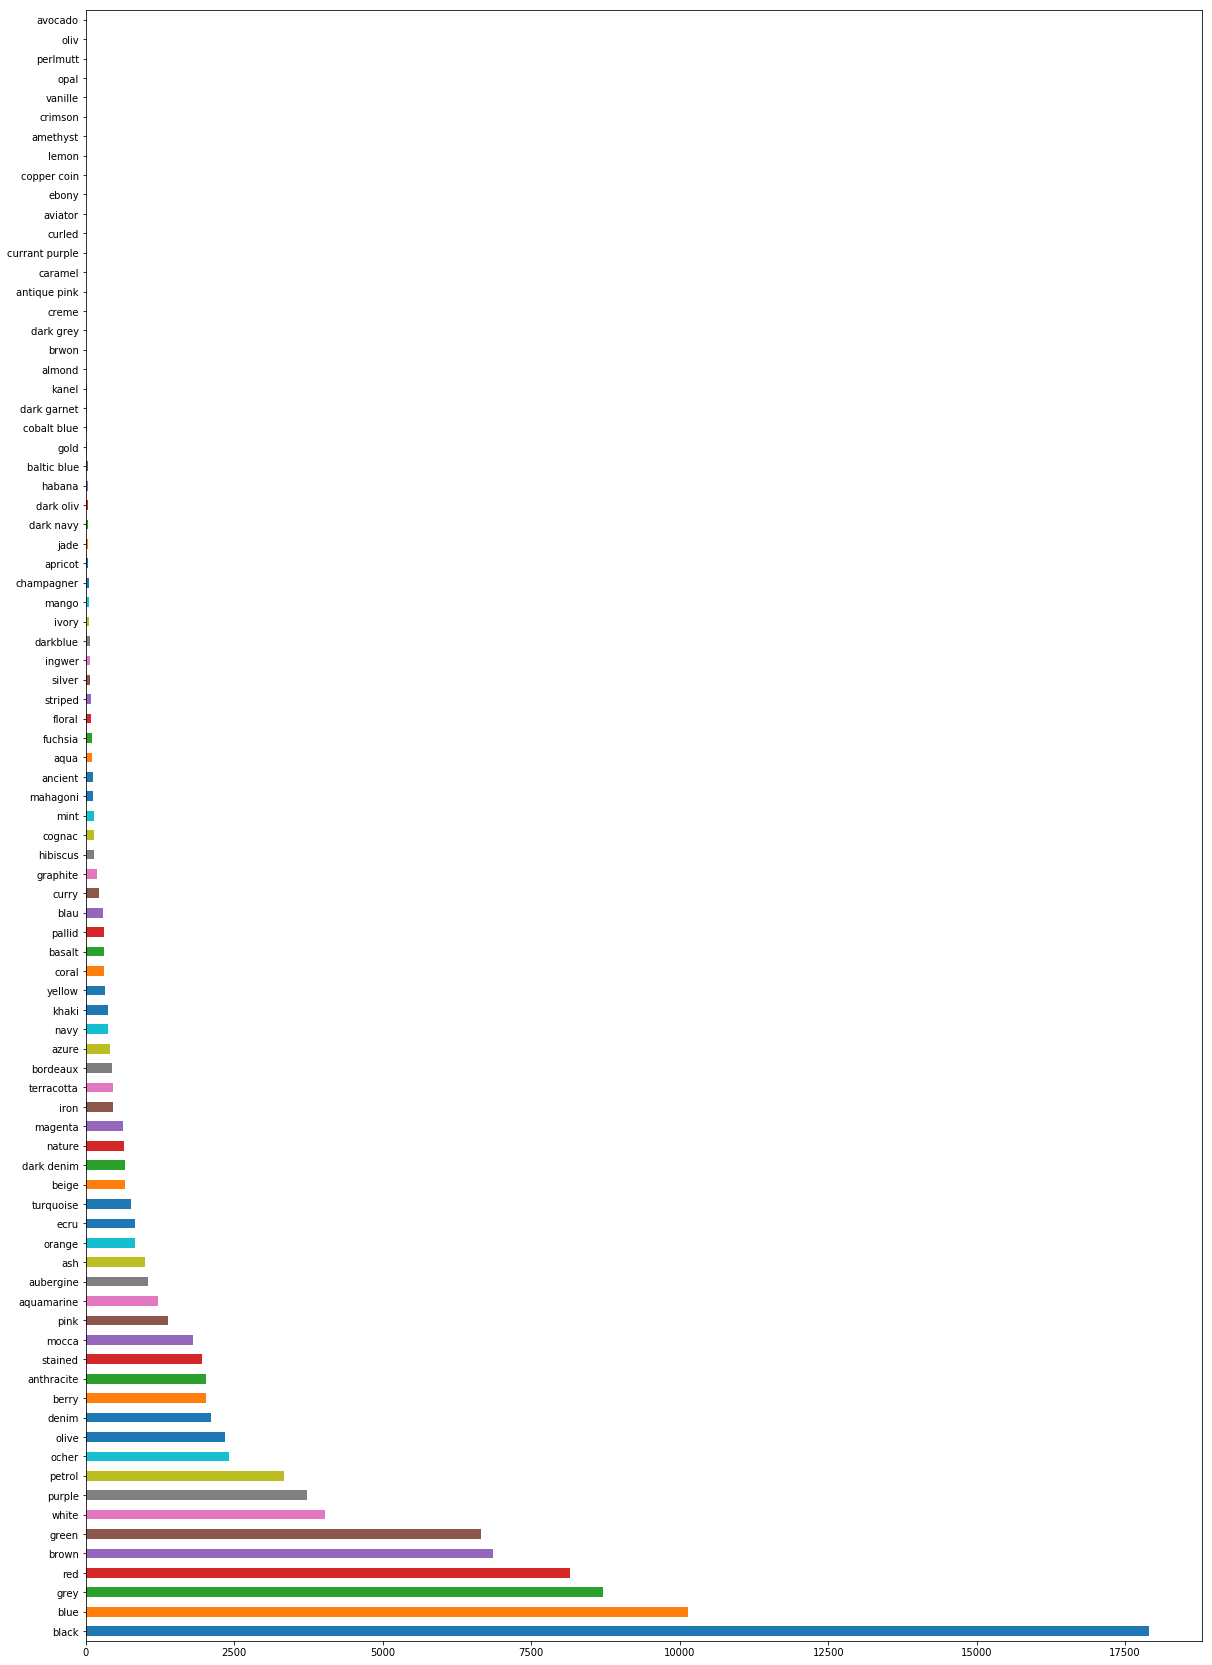

In [18]:
color_count = known.item_color.value_counts()
color_count.plot(kind="barh", figsize=(20, 30))

In [19]:
known.item_color.unique()

array(['red', 'grey', 'ecru', 'terracotta', 'petrol', 'purple', 'ocher',
       'black', 'aquamarine', 'mocca', 'blue', 'brown', 'aubergine',
       'white', 'green', 'berry', 'anthracite', 'stained', 'olive',
       'denim', 'iron', 'magenta', 'beige', 'ancient', 'dark denim',
       'nature', 'azure', 'basalt', 'blau', 'cognac', 'pink', 'ash',
       'navy', 'turquoise', 'mint', 'aqua', 'gold', 'striped', 'apricot',
       'darkblue', 'mahagoni', 'yellow', 'khaki', 'orange', 'dark grey',
       'graphite', 'champagner', 'mango', 'bordeaux', 'curry', 'coral',
       'pallid', 'fuchsia', 'dark oliv', 'silver', 'hibiscus', 'floral',
       'dark navy', 'jade', nan, 'ingwer', 'baltic blue', 'cobalt blue',
       'ivory', 'habana', 'creme', 'antique pink', 'avocado',
       'dark garnet', 'almond', 'caramel', 'currant purple', 'kanel',
       'ebony', 'aviator', 'brwon', 'opal', 'crimson', 'vanille', 'oliv',
       'lemon', 'copper coin', 'perlmutt', 'amethyst', 'curled'],
      dtype=obj

In [25]:
colordict = {
    "redish": ["red", "terracotta", "magenta", "bordeaux", "crimson"],
    "greyish": ["grey", "ash", "anthracite",
                "iron", "basalt", "dark grey", "graphite"],
    "whiteish": ["ecru", "white", "ivory", "creme", "vanille"],
    "blueish": ["azure", "darkblue", "dark navy", "opal", "blue", "navy",
                "baltic blue", "cobalt blue" "turquoise", "aqua", "petrol",
                "aquamarine", "denim", "dark denim", "blau"],
    "purpleish": ["purple", "aubergine", "amethyst", "berry", "dark garnet",
                  "currant purple"],
    "yellowish": ["ocher", "yellow", "champagner", "lemon"],
    "blackish": ["black"],
    "brownish": ["mocca", "brown", "cognac", "habana", "mahagoni", "ingwer",
                 "caramel", "kanel", "ebony", "brwon"],
    "greenish": ["green", "oliv", "olive", "mint", "dark oliv", "jade",
                 "avocado"],
    "stained": ["stained"],
    "beige": ["beige"],
    "ancient": ["ancient"],
    "nature": ["nature"],
    "pinkish": ["pink", "coral", "fuchsia", "hibiscus", "antique pink"],
    "metal": ["gold", "silver", "copper coin", "metal"],
    "striped": ["striped"],
    "orangeish": ["apricot", "curry", "orange", "mango"],
    "khaki": ["khaki"],
    "pallid": ["pallid"],
    "floral": ["floral"],
    "almond": ["almond"],
    "aviator": ["aviator"],
    "perlmutt": ["perlmutt"],
    "curled": ["curled"]
}

In [26]:
color_converter = {}
for key, vals in colordict.items():
    for val in vals:
        color_converter[val] = key

color_converter

{'red': 'redish',
 'terracotta': 'redish',
 'magenta': 'redish',
 'bordeaux': 'redish',
 'crimson': 'redish',
 'grey': 'greyish',
 'ash': 'greyish',
 'anthracite': 'greyish',
 'iron': 'greyish',
 'basalt': 'greyish',
 'dark grey': 'greyish',
 'graphite': 'greyish',
 'ecru': 'whiteish',
 'white': 'whiteish',
 'ivory': 'whiteish',
 'creme': 'whiteish',
 'vanille': 'whiteish',
 'azure': 'blueish',
 'darkblue': 'blueish',
 'dark navy': 'blueish',
 'opal': 'blueish',
 'blue': 'blueish',
 'navy': 'blueish',
 'baltic blue': 'blueish',
 'cobalt blueturquoise': 'blueish',
 'aqua': 'blueish',
 'petrol': 'blueish',
 'aquamarine': 'blueish',
 'denim': 'blueish',
 'dark denim': 'blueish',
 'blau': 'blueish',
 'purple': 'purpleish',
 'aubergine': 'purpleish',
 'amethyst': 'purpleish',
 'berry': 'purpleish',
 'dark garnet': 'purpleish',
 'currant purple': 'purpleish',
 'ocher': 'yellowish',
 'yellow': 'yellowish',
 'champagner': 'yellowish',
 'lemon': 'yellowish',
 'black': 'blackish',
 'mocca': 'bro

Save this bad boy to a `json`-file

In [27]:
known.loc[:, "item_color"] = known.loc[:, "item_color"].apply(
    lambda x: color_converter.get(x, np.nan))

In [28]:
item_color_counts = known.item_color.value_counts()
rare_colors = item_color_counts[item_color_counts < 1000]

for key in rare_colors.index:
    if key == "metal":
        continue
    color_converter[key] = "other"

color_converter["?"] = "other"

In [29]:
with open(os.path.join("..", "data", "colorconverter.json"), "w") as f:
    json.dump(color_converter, f)

***
# By the way, how does the unknown dataset look?

In [161]:
unknown.head()

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date
order_item_id,,,,,,,,,,,,
ID100001,2016-04-23,2016-04-26,244,40,black,61,59.90,12206,Mrs,1949-11-21,Bavaria,2015-11-24
ID100002,2017-01-28,2017-02-04,2655,XL,denim,31,89.90,6578,Family,1977-11-23,North Rhine-Westphalia,2015-12-23
ID100003,2017-01-19,2017-05-03,2823,unsized,brown,158,59.90,26094,Mrs,NaT,North Rhine-Westphalia,2016-06-04
ID100004,2016-04-23,2016-04-26,402,l,grey,46,29.90,12345,Mrs,1958-10-08,Lower Saxony,2015-02-17
ID100005,2016-04-04,2016-04-06,31,38,red,22,39.98,2557,Mr,1971-02-10,Hesse,2015-02-17


In [162]:
unknown.describe(include="all")

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date
count,50000,45947,50000,50000,50000,50000,50000.000000,50000,50000,44881,50000,50000
unique,365,310,2481,110,82,149,NaN,26566,5,10527,16,774
top,2016-06-27 00:00:00,2016-07-03 00:00:00,1415,l,black,3,NaN,2649,Mrs,1900-11-21 00:00:00,North Rhine-Westphalia,2015-02-17 00:00:00
freq,584,580,379,3854,9043,6780,NaN,44,47994,424,11517,14652
first,2016-04-01 00:00:00,1994-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-11-21 00:00:00,NaN,2015-02-17 00:00:00
last,2017-03-31 00:00:00,2017-07-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-11-25 00:00:00,NaN,2017-04-01 00:00:00
mean,NaN,NaN,NaN,NaN,NaN,NaN,70.473694,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,45.995238,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,34.900000,NaN,NaN,NaN,NaN,NaN


It looks just as shitty...